In [1]:
import numpy as np
import scipy.signal as sps
import soundfile as sf

def loadToMono(path, new_sr):
    data, sr = sf.read(path)
    print('path:', path)
    print('original data size:', len(data))
    print('original samplerate:', sr)
    
    
    data_mono = []
    for i in range(len(data)):
        data_mono.append((data[i][0] + data[i][1]) / 2)
    
    ret = np.asarray(data_mono)
    samples = round(len(ret) * float(new_sr) / sr)
    ret = sps.resample(np.asarray(ret), samples)
    
    print('new data size:', len(ret))
    print('new samplerate:', new_sr)
    print(' ')
    
    return ret

# Statt das kleinere Array mit Nullen zu erweitern, wird das größere gekürzt. --> Keine unnötigen Nullen    
def add(waves):
    if len(waves) == 1:
        return waves[0]
    elif len(waves) == 0:
        return []

    a = waves[0]
    b = waves[1]
    combined = []
    if len(a) >= len(b):
        combined = b + a[:len(b)]
    else:
        combined = a + b[:len(a)]
    
    if len(waves) > 2:
        return add([combined] + waves[2:])
    elif len(waves) == 2:
        return combined

# Ein Signal sollte mit mindestens der doppelten Frequenz abgetastet(gesampled) werden (Nyquist Sampling Theorem). 
# Auch wenn 8kHz mehr als doppelt so viel ist bei unseren bisherigen Noten, 
# sollten wir imo an die gesamte menschliche Hörweite denken --> samplerate mind. 40kHz
samplerate = 44100

# pp = sehr leise, mf = ziemlich laut, ff = sehr laut (Begriffe aus der Musik)
# Wir sollten gerade am Anfang die lauteren nehmen um sie einfacher trennen zu können, 
# aber für spätere Tests ist es gut die leiseren zu haben
a4 = loadToMono('files/Piano.mf.A4.aiff', samplerate) 
g5 = loadToMono('files/Piano.mf.G5.aiff', samplerate)

data_mono = add([a4, g5])

path: files/Piano.mf.A4.aiff
original data size: 1322313
original samplerate: 44100
new data size: 1322313
new samplerate: 44100
 
path: files/Piano.mf.G5.aiff
original data size: 861579
original samplerate: 44100
new data size: 861579
new samplerate: 44100
 


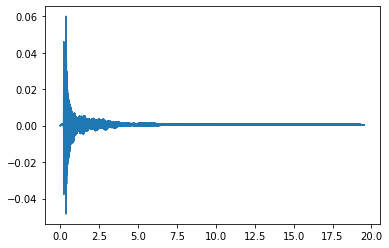

In [2]:
from matplotlib import pyplot

t = [(i) * 1/samplerate for i in range(data_mono.size)]

pyplot.plot(t, data_mono)
pyplot.show()

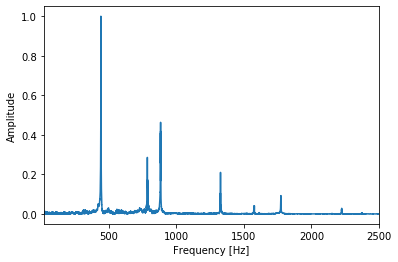

In [3]:
import matplotlib.pyplot as plt
s = np.asarray(data_mono)
fft = np.fft.fft(s)
T = 1/samplerate  # sampling interval 
N = s.size

# 1/T = frequency
f = np.linspace(0, 1 / T, N)

x = f[round(N/samplerate*20):N // 2] # ab ~20Hz starten um Peak bei 0 auszufiltern
y = np.abs(fft)[round(N/samplerate*20):N // 2]

# evtl. so normalisieren, denn so sind alle Amplituden im Verhältnis zu der größten Amplitude gegeben. 
# --> Feste Grenzen können im nächsten Schritt leichter festgelegt werden
y = y/max(y)

a = round(100*N/samplerate)
b = round(2500*N/samplerate) # Angabe in Hz

plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.xlim(20, 2500)
plt.plot(x, y)
plt.show()

[(440.65296467644254, 1.0), (785.0778455345888, 0.2858320785286107), (883.0974096367363, 0.4633192173595557), (1326.9238536731439, 0.20997797514221178), (1774.2820731262868, 0.09267265967516856)]


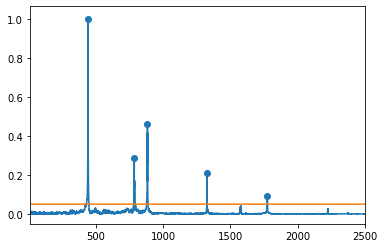

In [4]:
def findAllAbove(freq, amp, a, discreteTolerance):
    c = amp >= a
    
    maxs = []
    curMax = []
    toleranceCounter = 0
    firstSignal = False

    for i in range(len(y)):
        if c[i]: 
            curMax.append((freq[i], amp[i]))
            firstSignal = True
        else:
            if len(curMax) == 0:
                continue
            else:
                if toleranceCounter > discreteTolerance:
                    m = np.max([x[1] for x in curMax])
                    f = freq[np.where(amp == m)][0]
                    
                    if f > 0.5:
                        maxs.append((f, m))
                    
                    curMax = []
                    toleranceCounter = 0
                    firstSignal = False
                else:
                    if firstSignal:
                        toleranceCounter += 1
    
    return maxs

threshold = 0.05
maxs = findAllAbove(x, y, threshold, 100)
print(maxs)

plt.xlim(10, 2500)
plt.plot(x, y)
plt.plot(x, [threshold] * len(x))
plt.scatter(*zip(*maxs))
plt.show()


# Threshold muss hoch genug gewählt werden, da sonst das Rauschen mitkommt.
# Wenn dabei nur die Grundschwingung einer Note aufgenommen wird,
# ist das nicht so kritisch, da dann klar ist das diese Note angeschlagen wurde.

In [5]:
def filterMultiples(maxs, tol):
    copy = [m for m in maxs]
    mults = []
    cur = []
    
    while len(copy) > 0:
        cur.append(copy[0])
        del copy[0]
        
        removed = 0
        for i in range(len(copy)):
            ratio = copy[i - removed][0] / cur[0][0]
            if abs(ratio - round(ratio)) < tol:
                cur.append(copy[i - removed])
                del copy[i - removed]
                removed += 1
                
        mults.append(cur)
        cur = []
    
    return mults
        
    
mults = filterMultiples(maxs, 0.1)
mults

[[(440.65296467644254, 1.0),
  (883.0974096367363, 0.4633192173595557),
  (1326.9238536731439, 0.20997797514221178),
  (1774.2820731262868, 0.09267265967516856)],
 [(785.0778455345888, 0.2858320785286107)]]

In [6]:
def getNoteFreqs(mults):
    """
    Ermittelt die angeschlagenen Frequenzen.
    
    Aus jeder Liste von Grund- und Oberschwingungen wird die maximale Amplitude der Liste herausgesucht
    und mit den anderen Amplituden verglichen. Fallen die anderen Amplituden nicht ab, wurden diese ebenfalls angeschlagen.
    Fallen sie ab, werden sie nicht aufgenommen, da es entweder Oberschwingungen oder Fehler sind.
    Z.b. A4 und A5 angeschlagen: 440Hz und 880Hz müssen aufgenommen werden.
    """
    ret = []
    
    maximum = 0
    
    for i in range(len(mults)):
        for j in range(len(mults[i])):
            if mults[i][j][1] > maximum:
                maximum = mults[i][j][1]
        for j in range(len(mults[i])):
            if mults[i][j][1]/maximum >= 0.55:
                ret.append(mults[i][j][0])
        maximum = 0
                
    return ret

noteFreqs = getNoteFreqs(mults)
noteFreqs

[440.65296467644254, 785.0778455345888]

In [7]:
"""
Für eine Erkennung der Melodie müssen wir die Sound-Datei nachher in kleinen Schritten analysieren,
denn es bringt nichts die Noten aus dem ganzen Musikstück zu kennen; wir brauchen die Noten in einer Reihenfolge.

Wir nehmen also immer x ms und analysieren sie wie hier und schreiben die Noten raus, danach die nächsten x ms usw.
Evtl. müssen wir dabei unterschiedliche Fenster-Funktionen ausprobieren.

scipy.signal.stft tut genau das und die Fensterfunktion ist wählbar.
"""

'\nFür eine Erkennung der Melodie müssen wir die Sound-Datei nachher in kleinen Schritten analysieren,\ndenn es bringt nichts die Noten aus dem ganzen Musikstück zu kennen; wir brauchen die Noten in einer Reihenfolge.\n\nWir nehmen also immer x ms und analysieren sie wie hier und schreiben die Noten raus, danach die nächsten x ms usw.\nEvtl. müssen wir dabei unterschiedliche Fenster-Funktionen ausprobieren.\n\nscipy.signal.stft tut genau das und die Fensterfunktion ist wählbar.\n'